In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.svm import SVC

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, precision_score, recall_score, plot_roc_curve, roc_curve
import scikitplot as skplt
from collections import Counter

In [2]:
df = pd.read_csv('winequality-red.csv')

In [3]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
def get_quant_features(dataframe):
    feats = dataframe.select_dtypes([np.number, np.bool]).columns
    return [x for x in feats]

In [5]:
def draw_histograms(dataframe, variables, n_rows, n_cols):
    
    fig=plt.figure(figsize=(16,10))
    
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows, n_cols, i+1)
        dataframe[var_name].hist(bins=20, ax=ax)
        ax.set_title(var_name)
        
    fig.tight_layout()
    
    plt.show()

<ipython-input-4-ca7b4ef15165>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  feats = dataframe.select_dtypes([np.number, np.bool]).columns


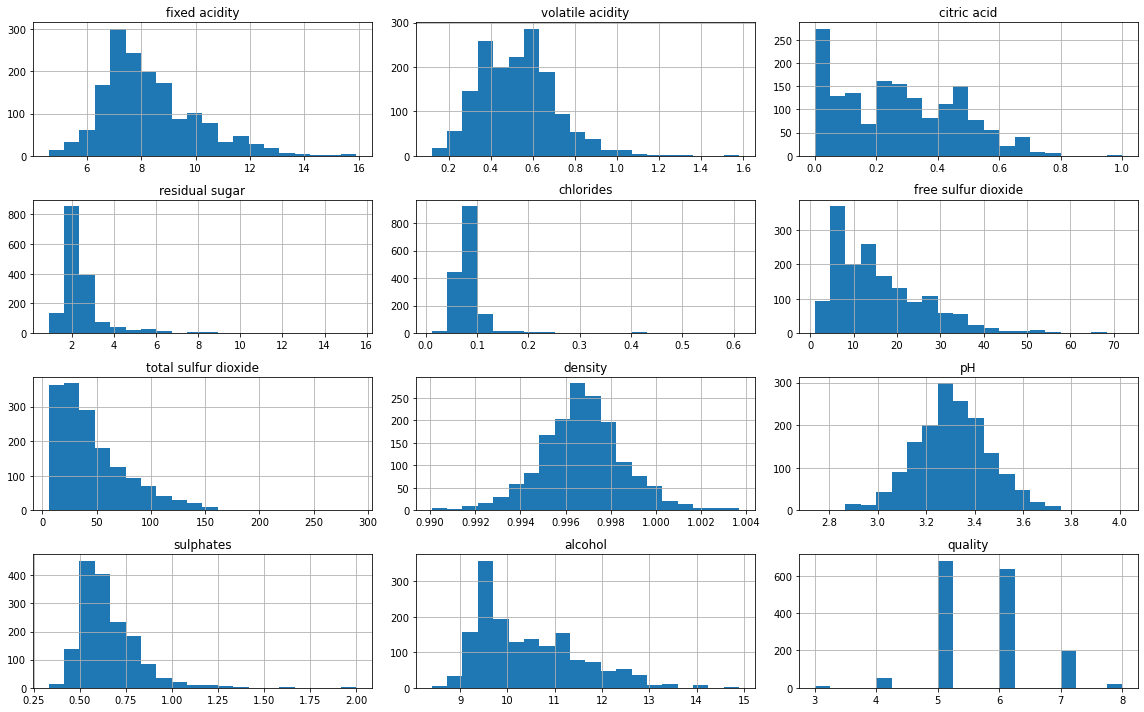

In [6]:
feats = get_quant_features(df)
draw_histograms(df, feats, 4, 3)

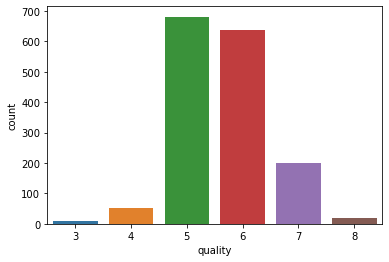

In [7]:
sns.countplot(x=df.quality);

In [8]:
df.quality.value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [9]:
df["good"] = 0
df.loc[df["quality"]>=6,"good"] = 1

In [11]:
df.good.value_counts()

1    855
0    744
Name: good, dtype: int64

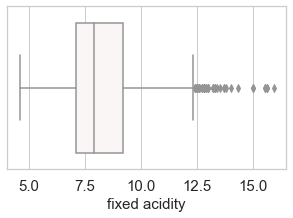

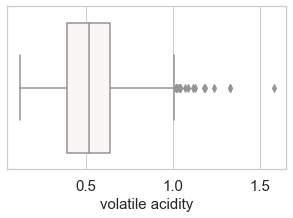

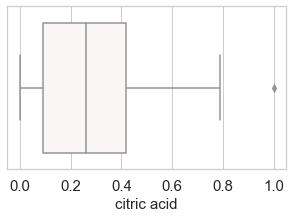

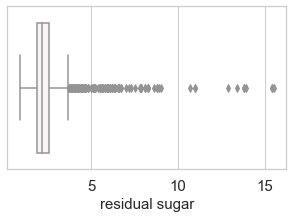

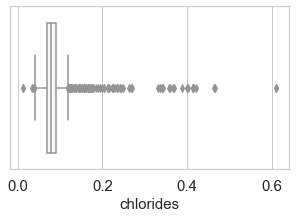

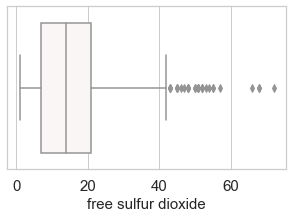

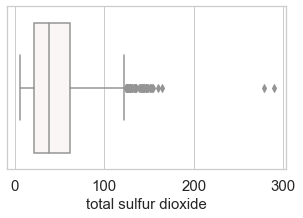

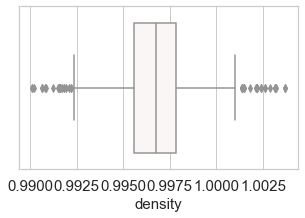

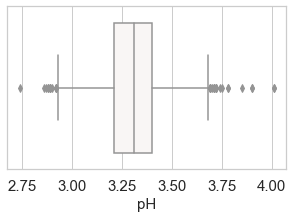

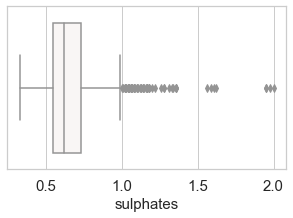

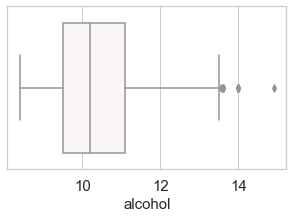

In [12]:
# Boxploty

sns.set_theme(style="whitegrid")

list_columns = list(df.drop(columns= ["quality","good"], axis=1).columns)

for column in list_columns:
    f, ax = plt.subplots(figsize=(5, 3))
    sns.boxplot(x=df[column], palette="vlag")
    ax.set_xlabel(column,fontsize=15)
    ax.tick_params(labelsize=15);

### Podział na zbiór treningowy i testowy

In [13]:
# Podział na zbiór treningowy i testowy

X = df.drop(columns= ["quality","good"], axis=1)
y = df.good

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = df.quality, random_state=0)
y_train.value_counts()

1    598
0    521
Name: good, dtype: int64

In [14]:
y_test.value_counts()

1    257
0    223
Name: good, dtype: int64

### Oversampling / Undersampling   - zakomentowane

In [15]:
# # instantiating over and under sampler
# over_strategy = {3: 177, 4: 177, 8: 177}                      # 50% średniej z 3 najliczniejszych klas
# over = RandomOverSampler(sampling_strategy=over_strategy)
# under_strategy = {5: 382, 6: 357}                             # 80% wartości każdej z dwóch najliczniejszych klas
# under = RandomUnderSampler(sampling_strategy=under_strategy)

# # first performing oversampling to minority class
# X_over, y_over = over.fit_resample(X_train, y_train)
# print(f"Oversampled: {Counter(y_over)}")

# # now to comine under sampling 
# X_combined, y_combined = under.fit_resample(X_over, y_over)
# print(f"Combined Random Sampling: {Counter(y_combined)}")

In [16]:
# y_combined.value_counts()

### Usuwanie outlier'ów

In [17]:
# # Boxploty przed usunięciem outlier'ów

# sns.set_theme(style="whitegrid")

# list_columns_comb = list(X.columns)

# for column in list_columns_comb:
#     f, ax = plt.subplots(figsize=(5, 3))
#     sns.boxplot(x=X[column], palette="vlag")
#     ax.set_xlabel(column,fontsize=15)
#     ax.tick_params(labelsize=15);

### Normalizacja

In [18]:
# Normalizacja zestawu treningowego do rozkładu normalnego, wyznaczenie wartości średnich i odchyleń standardowych
# https://stats.stackexchange.com/questions/174823/how-to-apply-standardization-normalization-to-train-and-testset-if-prediction-i

scaler = StandardScaler()
scaler.fit(X_train)

X_train_std = scaler.transform(X_train)

print(scaler.mean_, scaler.scale_)

[ 8.30643432  0.52852547  0.27336014  2.56076854  0.08840036 16.11438785
 47.22162645  0.99678033  3.31168007  0.65832887 10.40682157] [1.71323859e+00 1.78561342e-01 1.95152070e-01 1.45967321e+00
 4.99490235e-02 1.02890903e+01 3.30313110e+01 1.90085602e-03
 1.54261600e-01 1.71224301e-01 1.05955405e+00]


In [19]:
# Normalizacja zestawu testowego do rozkładu normalnego z wykorzystaniem wartości średnich i odch. std z zestawu treningowego

X_test_std = scaler.transform(X_test)

## SVC

In [20]:
# SVC?

In [21]:
parameters_SVC = {
    "C": [0.1, 1, 10, 50],
    "gamma": [0.0001, 0.0005, 0.001, 0.005], 
    "kernel": ('linear','poly','rbf', 'sigmoid'),
    "degree": [2,4] 
    
}

model_SVC = SVC(probability=True)
model_SVC_with_best_params = GridSearchCV(model_SVC, parameters_SVC)
model_SVC_with_best_params.fit(X_train_std,y_train)
model_SVC_best_params = model_SVC_with_best_params.best_params_

In [22]:
model_SVC_best_params

{'C': 10, 'degree': 2, 'gamma': 0.005, 'kernel': 'rbf'}

In [23]:
predictions_SVC = model_SVC_with_best_params.predict(X_test_std)

              precision    recall  f1-score   support

           0      0.752     0.762     0.757       223
           1      0.791     0.782     0.787       257

    accuracy                          0.773       480
   macro avg      0.772     0.772     0.772       480
weighted avg      0.773     0.773     0.773       480

Overall Accuracy: 0.7729166666666667
Overall Precision: 0.7717754860288482
Overall Recall: 0.7722165029400987


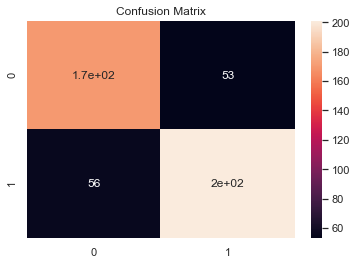

In [24]:
cm = confusion_matrix(y_test, predictions_SVC)
sns.heatmap(cm, annot=True)
plt.title("Confusion Matrix")
    
acc = accuracy_score(y_test, predictions_SVC)
pre = precision_score(y_test, predictions_SVC, average="macro")
rec = recall_score(y_test, predictions_SVC, average="macro")
# Prediction Report
print(classification_report(y_test, predictions_SVC, digits=3))
print("Overall Accuracy:", acc)
print("Overall Precision:", pre)
print("Overall Recall:", rec)

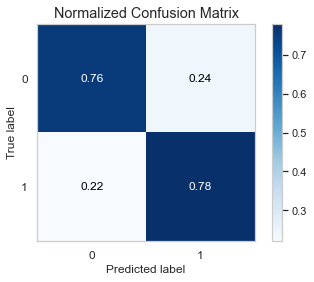

In [25]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred=predictions_SVC, normalize=True)
plt.show()

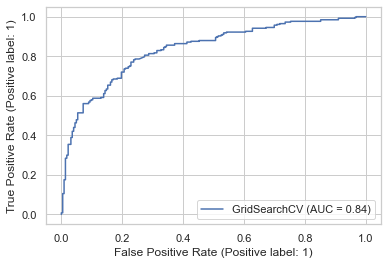

In [26]:
plot_roc_curve(model_SVC_with_best_params, X_test_std, y_test)
y_score = model_SVC_with_best_params.predict_proba(X_test_std)[:, 1]
fpr, tpr, threshold = roc_curve(y_test, y_score)
auc = roc_auc_score(y_test, y_score)

In [27]:
auc

0.835354469473574

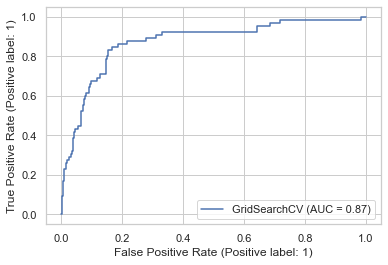

In [61]:
plot_roc_curve(model_SVC_with_best_params, X_test_std, y_test)
pass